<a href="https://colab.research.google.com/github/matteo-cutroni/CV-project/blob/main/Efficient_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hyperparameters

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.0002
BATCH_SIZE = 128
IMAGE_SIZE = 64         # resize CIFAR-10 to 64x64
CHANNELS_IMG = 3
Z_DIM = 100             # noise dimension
NUM_EPOCHS = 50
FEATURES_G = 64
FEATURES_D = 64

# Utils

In [3]:
def show_images(images):
    # reverse the normalization
    images = images * 0.5 + 0.5
    img_grid = make_grid(images, nrow=8)
    img_grid_np = img_grid.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(img_grid_np)
    plt.axis('off')
    plt.show()

# Dataset

In [4]:
# normalize in range [-1.0, 1.0]
transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(CHANNELS_IMG)],
        [0.5 for _ in range(CHANNELS_IMG)]
    )
])

dataset = datasets.CIFAR10(
    root="dataset/",
    train=True,
    transform=transforms,
    download=True
)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2 # num_workers=2 is recommended by Colab
)

100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


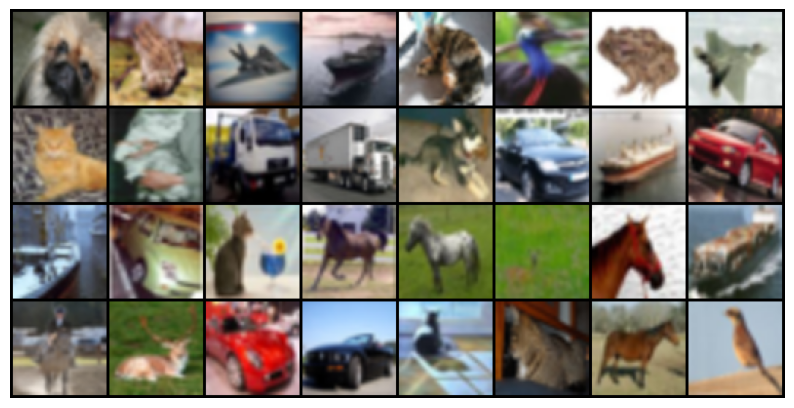

In [5]:
real_batch = next(iter(dataloader))
images, labels = real_batch

show_images(images[:32])

# Network

In [6]:
# same structure as DCGAN pytorch tutorial
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(

            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            self._block(features_d, features_d * 2),
            self._block(features_d * 2, features_d * 4),
            self._block(features_d * 4, features_d * 8),

            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(

            self._block(z_dim, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),

            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.gen(x)


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)



gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_G).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_D).to(device)
gen.apply(weights_init)
disc.apply(weights_init)

# using the paper's recommended parameters
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

# Train

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50] Loss D: 0.9385, Loss G: 1.2525


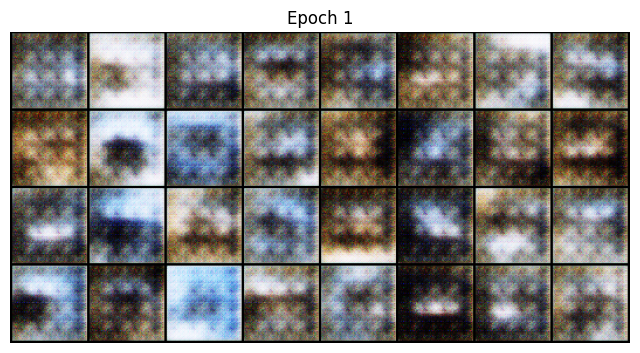

  4%|▍         | 2/50 [03:24<1:21:53, 102.37s/it]

Epoch [2/50] Loss D: 1.0485, Loss G: 1.4049


  6%|▌         | 3/50 [05:07<1:20:26, 102.70s/it]

Epoch [3/50] Loss D: 0.9188, Loss G: 2.2535


  8%|▊         | 4/50 [06:50<1:18:49, 102.80s/it]

Epoch [4/50] Loss D: 0.8222, Loss G: 2.1483
Epoch [5/50] Loss D: 0.6306, Loss G: 1.9775


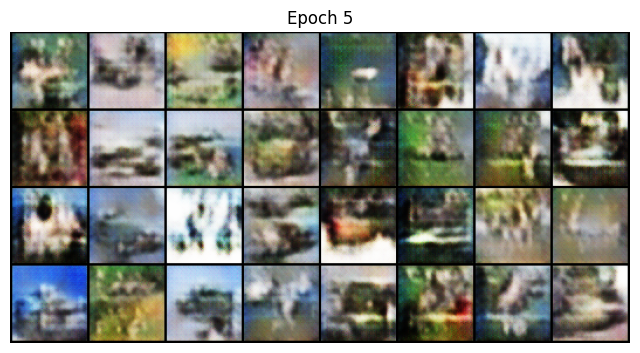

 12%|█▏        | 6/50 [10:16<1:15:33, 103.04s/it]

Epoch [6/50] Loss D: 0.9637, Loss G: 1.8384


 14%|█▍        | 7/50 [11:59<1:13:52, 103.07s/it]

Epoch [7/50] Loss D: 0.2539, Loss G: 5.5946


 16%|█▌        | 8/50 [13:43<1:12:09, 103.08s/it]

Epoch [8/50] Loss D: 0.0115, Loss G: 5.7875


 18%|█▊        | 9/50 [15:26<1:10:26, 103.08s/it]

Epoch [9/50] Loss D: 0.5773, Loss G: 4.5445
Epoch [10/50] Loss D: 0.2488, Loss G: 4.8300


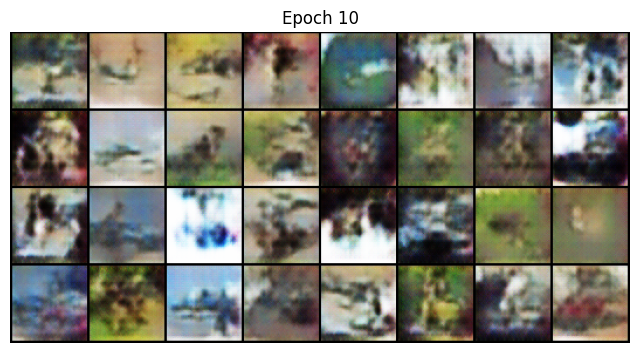

 22%|██▏       | 11/50 [18:52<1:07:03, 103.17s/it]

Epoch [11/50] Loss D: 0.9416, Loss G: 2.0912


 24%|██▍       | 12/50 [20:35<1:05:20, 103.16s/it]

Epoch [12/50] Loss D: 0.0205, Loss G: 5.6195


 26%|██▌       | 13/50 [22:18<1:03:35, 103.12s/it]

Epoch [13/50] Loss D: 0.0153, Loss G: 5.3286


 28%|██▊       | 14/50 [24:01<1:01:52, 103.11s/it]

Epoch [14/50] Loss D: 0.2036, Loss G: 4.1449
Epoch [15/50] Loss D: 0.7566, Loss G: 4.4451


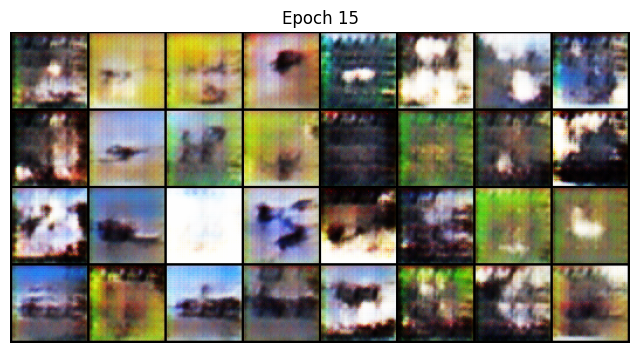

 32%|███▏      | 16/50 [27:28<58:26, 103.13s/it]  

Epoch [16/50] Loss D: 2.5631, Loss G: 9.0129


 34%|███▍      | 17/50 [29:11<56:42, 103.11s/it]

Epoch [17/50] Loss D: 0.5097, Loss G: 1.8332


 36%|███▌      | 18/50 [30:54<54:58, 103.09s/it]

Epoch [18/50] Loss D: 0.1485, Loss G: 5.5925


 38%|███▊      | 19/50 [32:37<53:15, 103.07s/it]

Epoch [19/50] Loss D: 1.3706, Loss G: 1.8966
Epoch [20/50] Loss D: 0.0055, Loss G: 7.9221


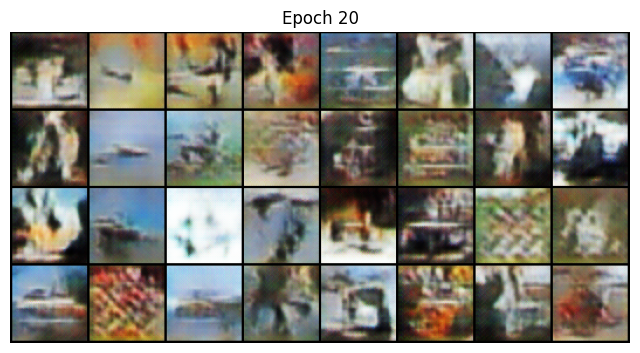

 42%|████▏     | 21/50 [36:03<49:51, 103.15s/it]

Epoch [21/50] Loss D: 0.0902, Loss G: 3.6548


 44%|████▍     | 22/50 [37:46<48:06, 103.10s/it]

Epoch [22/50] Loss D: 0.2863, Loss G: 3.5659


 46%|████▌     | 23/50 [39:30<46:24, 103.12s/it]

Epoch [23/50] Loss D: 0.9284, Loss G: 7.2468


 48%|████▊     | 24/50 [41:13<44:40, 103.10s/it]

Epoch [24/50] Loss D: 0.1840, Loss G: 4.4578
Epoch [25/50] Loss D: 0.0240, Loss G: 5.2919


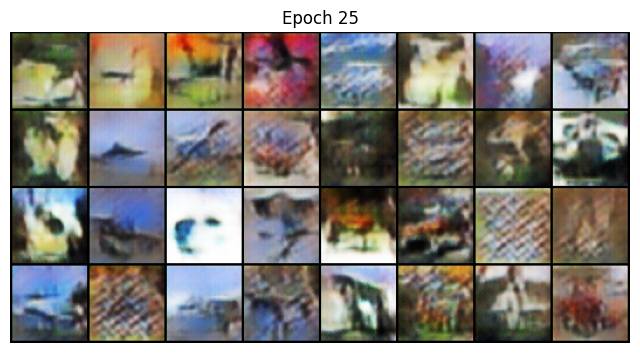

 52%|█████▏    | 26/50 [44:39<41:14, 103.12s/it]

Epoch [26/50] Loss D: 0.0745, Loss G: 4.2981


 54%|█████▍    | 27/50 [46:22<39:31, 103.11s/it]

Epoch [27/50] Loss D: 0.3322, Loss G: 3.3636


 56%|█████▌    | 28/50 [48:05<37:47, 103.07s/it]

Epoch [28/50] Loss D: 0.5335, Loss G: 2.9853


 58%|█████▊    | 29/50 [49:48<36:04, 103.09s/it]

Epoch [29/50] Loss D: 0.3350, Loss G: 3.4628
Epoch [30/50] Loss D: 0.1584, Loss G: 4.4671


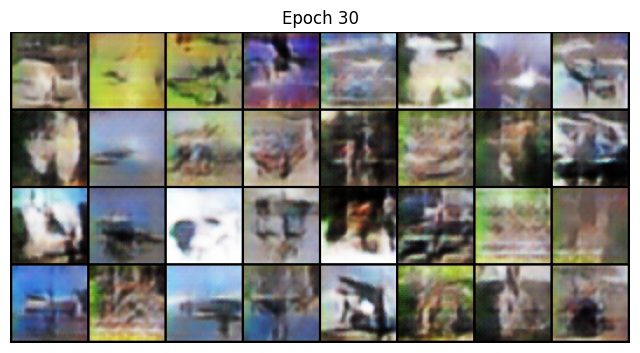

 62%|██████▏   | 31/50 [53:14<32:38, 103.10s/it]

Epoch [31/50] Loss D: 0.0031, Loss G: 7.8092


 64%|██████▍   | 32/50 [54:58<30:56, 103.12s/it]

Epoch [32/50] Loss D: 0.3552, Loss G: 1.7740


 66%|██████▌   | 33/50 [56:41<29:12, 103.09s/it]

Epoch [33/50] Loss D: 0.0164, Loss G: 7.3924


 68%|██████▊   | 34/50 [58:24<27:29, 103.09s/it]

Epoch [34/50] Loss D: 0.3776, Loss G: 2.2646
Epoch [35/50] Loss D: 0.3812, Loss G: 2.6529


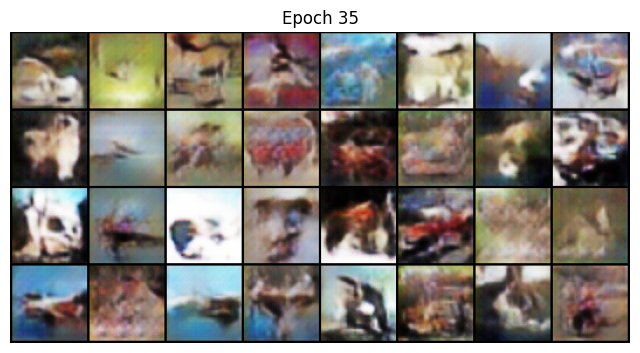

 72%|███████▏  | 36/50 [1:01:50<24:03, 103.11s/it]

Epoch [36/50] Loss D: 0.0018, Loss G: 10.7397


 74%|███████▍  | 37/50 [1:03:33<22:20, 103.10s/it]

Epoch [37/50] Loss D: 0.0851, Loss G: 4.4079


 76%|███████▌  | 38/50 [1:05:16<20:36, 103.08s/it]

Epoch [38/50] Loss D: 0.5344, Loss G: 3.6739


 78%|███████▊  | 39/50 [1:06:59<18:53, 103.05s/it]

Epoch [39/50] Loss D: 0.8228, Loss G: 4.0158
Epoch [40/50] Loss D: 1.2143, Loss G: 3.6376


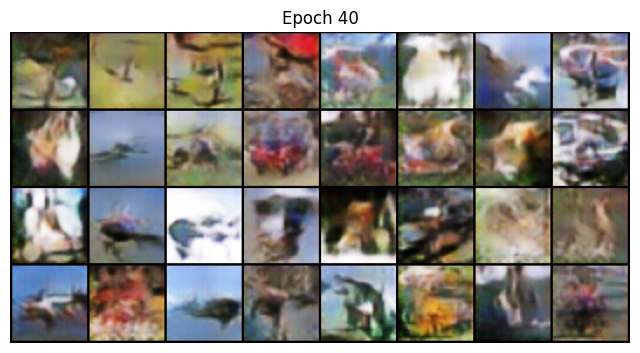

 82%|████████▏ | 41/50 [1:10:25<15:27, 103.09s/it]

Epoch [41/50] Loss D: 0.0294, Loss G: 5.6892


 84%|████████▍ | 42/50 [1:12:08<13:44, 103.08s/it]

Epoch [42/50] Loss D: 0.6654, Loss G: 4.7760


 86%|████████▌ | 43/50 [1:13:51<12:01, 103.06s/it]

Epoch [43/50] Loss D: 0.0064, Loss G: 8.3183


 88%|████████▊ | 44/50 [1:15:34<10:18, 103.07s/it]

Epoch [44/50] Loss D: 0.3071, Loss G: 3.2442
Epoch [45/50] Loss D: 0.0498, Loss G: 4.7973


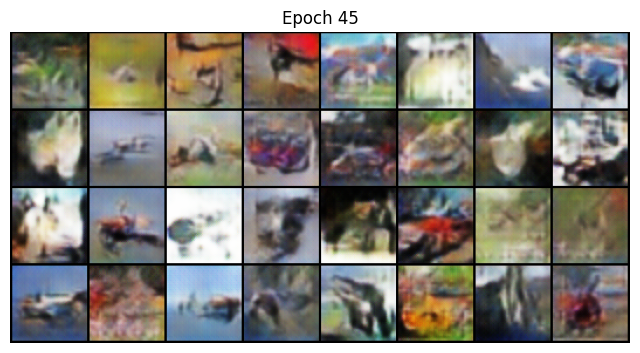

 92%|█████████▏| 46/50 [1:19:01<06:52, 103.12s/it]

Epoch [46/50] Loss D: 0.2719, Loss G: 4.2023


 94%|█████████▍| 47/50 [1:20:44<05:09, 103.08s/it]

Epoch [47/50] Loss D: 0.0295, Loss G: 4.6441


 96%|█████████▌| 48/50 [1:22:27<03:26, 103.06s/it]

Epoch [48/50] Loss D: 1.7717, Loss G: 0.0104


 98%|█████████▊| 49/50 [1:24:10<01:43, 103.06s/it]

Epoch [49/50] Loss D: 0.6508, Loss G: 2.1838
Epoch [50/50] Loss D: 0.3310, Loss G: 3.6054


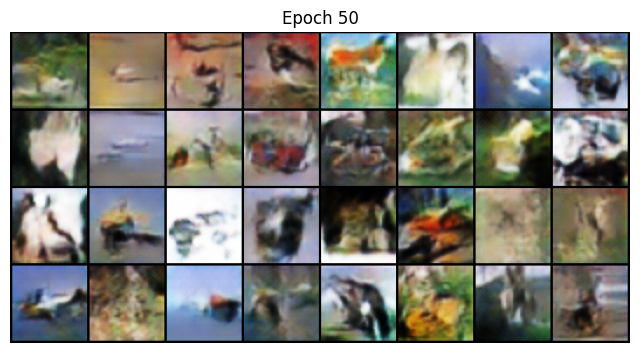

100%|██████████| 50/50 [1:25:53<00:00, 103.08s/it]


In [7]:
img_list = []
G_losses = []
D_losses = []

for epoch in tqdm(range(NUM_EPOCHS)):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        batch_size = real.shape[0]

        # Train Discriminator
        disc.zero_grad()

        # real data
        label = torch.ones((batch_size, 1, 1, 1)).to(device)
        output = disc(real)
        loss_d_real = criterion(output, label)
        loss_d_real.backward()

        # fake data
        noise = torch.randn(batch_size, Z_DIM, 1, 1).to(device)
        fake = gen(noise)
        label = torch.zeros((batch_size, 1, 1, 1)).to(device)
        output = disc(fake.detach()) # detach to avoid training generator on these gradients
        loss_d_fake = criterion(output, label)
        loss_d_fake.backward()

        loss_d = loss_d_real + loss_d_fake
        opt_disc.step()

        # Train Generator
        gen.zero_grad()
        label = torch.ones((batch_size, 1, 1, 1)).to(device) # disc thinks these are real
        output = disc(fake)
        loss_g = criterion(output, label)
        loss_g.backward()
        opt_gen.step()

        # save Losses for plotting later
        if batch_idx % 100 == 0:
            G_losses.append(loss_g.item())
            D_losses.append(loss_d.item())

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Loss D: {loss_d:.4f}, Loss G: {loss_g:.4f}")

    # visualize progress every 5 epochs
    if (epoch + 1) % 5 == 0 or epoch == 0:
        with torch.no_grad():
            fake = gen(fixed_noise)
            # denormalize
            img_grid = make_grid(fake * 0.5 + 0.5, normalize=False)
            plt.figure(figsize=(8, 8))
            plt.axis("off")
            plt.title(f"Epoch {epoch+1}")
            plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy())
            plt.show()